In [3]:
from thalpy.analysis import fc, pc, masks, denoise, kaiplot
import thalpy.base as base

import numpy as np
import nilearn
import pandas as pd
from nilearn.decoding import Decoder
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score
from sklearn import svm
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn import plotting

DATASET_DIR = "/mnt/nfs/lss/lss_kahwang_hpc/data/HCP_D/"
DIR_TREE = base.DirectoryTree(DATASET_DIR)
INTERVIEW_AGE = "interview_age"
print('nards')

def calc_fc(n_masker, m_masker):
    fc_data = fc.FcData(
        DATASET_DIR,
        n_masker,
        m_masker,
        "schaefer_thal",
        task="rest",
        cores=16,
    )
    fc_data.calc_fc()

    return fc_data


fc_data = fc.load_fc(DIR_TREE.analysis_dir + "schaefer_thal.p")
kaiplot.plot_TR_distribution(fc_data)


fc_data.fc_subjects = [
    subject
    for subject in fc_data.fc_subjects
    if subject is not None and subject.TR > 800
]

demographics_df = (
    pd.read_csv(DIR_TREE.bids_dir + "participants.tsv", sep="\t")
    .sort_values("participant_id")
    .set_index("participant_id")
)
demographics_df[INTERVIEW_AGE] = demographics_df[INTERVIEW_AGE].apply(
    lambda x: float(str(x)[:-1] + "." + str(x)[-1])
)

num_sub = len(fc_data.fc_subjects)
fc_array = np.zeros((num_sub, fc_data.n * fc_data.m))
age_array = np.zeros(num_sub)
for i, subject in enumerate(fc_data.fc_subjects):
    if subject is None:
        continue
    age = demographics_df.loc[int(subject.name), INTERVIEW_AGE]
    setattr(subject, "age", age)
    fc_array[i, :] = subject.seed_to_voxel_correlations.flatten()
    age_array[i] = age

print(f"Dataset contains {num_sub} subjects after removing high noise subjects.")


nards
Dataset contains 419 subjects after removing high noise subjects.


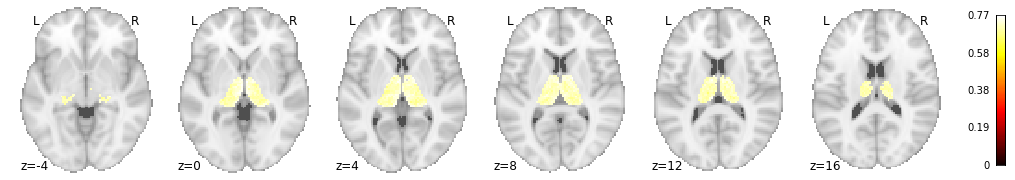

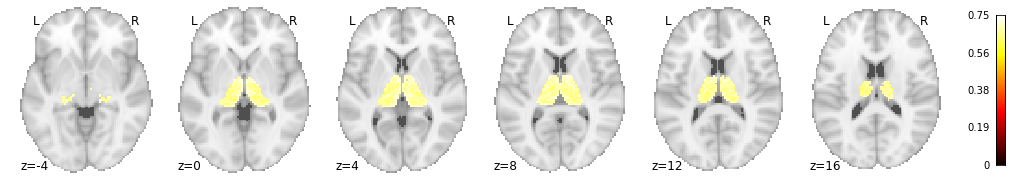

In [38]:
from thalpy.analysis import pc
from thalpy.analysis import plotting as kaiplot
# calculate pc
pc_matrix = pc.pc_dataset(np.swapaxes(fc_data.data, 0, 1), masks.SCHAEFER_7CI, thresholds=[90, 95], output_path=DIR_TREE.analysis_dir + 'pc_thal_schaefer')

for threshold in np.arange(pc_matrix.shape[1]):
    averaged_pc = np.nanmean(pc_matrix[:, threshold, :], axis=-1)
    print(np.min(averaged_pc))
    fc_data.m_masker.fit()
    img = fc_data.m_masker.inverse_transform(averaged_pc)
    kaiplot.plot_thal(img)

In [4]:
x_train, x_test, y_train, y_test = train_test_split(
    fc_array, age_array, test_size=0.2, random_state=0
)
print(f"Training data (80% of dataset) contains {len(x_train)} subjects")
print(f"Testing data (20% of dataset) contains {len(x_test)} subjects")

svr = svm.SVR(kernel="linear")
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
scores = cross_val_score(svr, x_train, y_train, cv=cv)
print(scores)
print(
    "%0.2f accuracy with a standard deviation of %0.2f" % (scores.mean(), scores.std())
)
svr.fit(x_train, y_train)

Training data (80% of dataset) contains 335
Testing data (20% of dataset) contains 84
[0.47408086 0.42833365 0.45859879 0.46831623 0.4299399 ]
0.45 accuracy with a standard deviation of 0.02


SVR(kernel='linear')

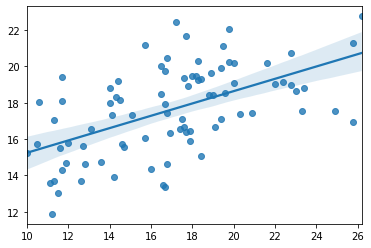

In [5]:
predicted_ages = svr.predict(x_test)
sns.regplot(x=y_test, y=predicted_ages)
plt.show()

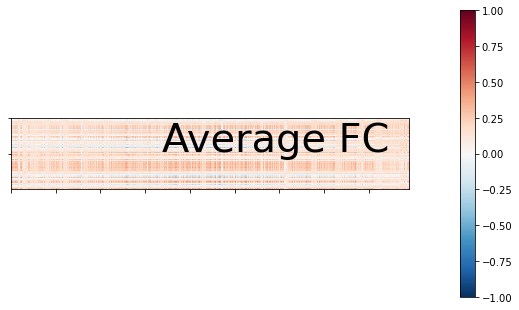

In [10]:


averaged_fc = np.mean(fc_data.data, axis=-1)
plotting.plot_matrix(averaged_fc, vmax=1, vmin=-1, title='Average FC')